Building Makemore - a language model to produce more of what it is fed

Lets begin by reading in the data and seeing the first 10 examples

In [1]:
with open('names.txt') as f:
	words = f.read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

We can start our language model as a basic bigram model that only considers two characters at a time, using the previous character to predict the next one. This means, each word packs in possibly multiple training examples. We will however need to tell the model when a word starts and ends, and for this purpose we can use special start (\<S>) and end (\<E>) characters appended onto individual words.

In [2]:
# Exploring bigrams
for word in words[:1]:
	chars = ['<S>']+list(word)+['<E>']
	for ch1, ch2 in zip(chars, chars[1:]):
		print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


Having seen how we can add starting and end characters, to build the bigram model, we need to know the counts of the individual character bigrams.

In [3]:
# Counting character bigrams
counts = {}
for word in words:
	chars = ['<S>']+list(word)+['<E>']
	for ch1, ch2 in zip(chars, chars[1:]):
		counts[(ch1, ch2)] = counts.get((ch1, ch2), 0) + 1

# Lets see what the 10 most common bigrams are
sorted(counts.items(), key=lambda item: -item[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

Moving forward, we can't keep the counts in a dictionary. We will instead move to using PyTorch. We can then store our count data in a 2D array, where the character represented by the column follows the character represented by the row. Therefore, we need a mapping from characters in our dataset to indices.

In [4]:
import torch

In [5]:
# Get all characters in dataset
chars = sorted(list(set(''.join(words))))
chars.append('<S>')
chars.append('<E>')

# Convert list of characters to index mapping
ctoi = {c: i for i, c in enumerate(chars)}

# Create reverse mapping
itoc = {i: c for c, i in ctoi.items()}

In [6]:
# We have 28 characters, so we need a 28x28 array
N = torch.zeros((28,28), dtype=torch.int32)

# Populate entries in N
for word in words:
	chars = ['<S>']+list(word)+['<E>']
	for ch1, ch2 in zip(chars, chars[1:]):
		idx1, idx2 = ctoi[ch1], ctoi[ch2]
		N[idx1, idx2] += 1

Now we want to visualize what this matrix looks like

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

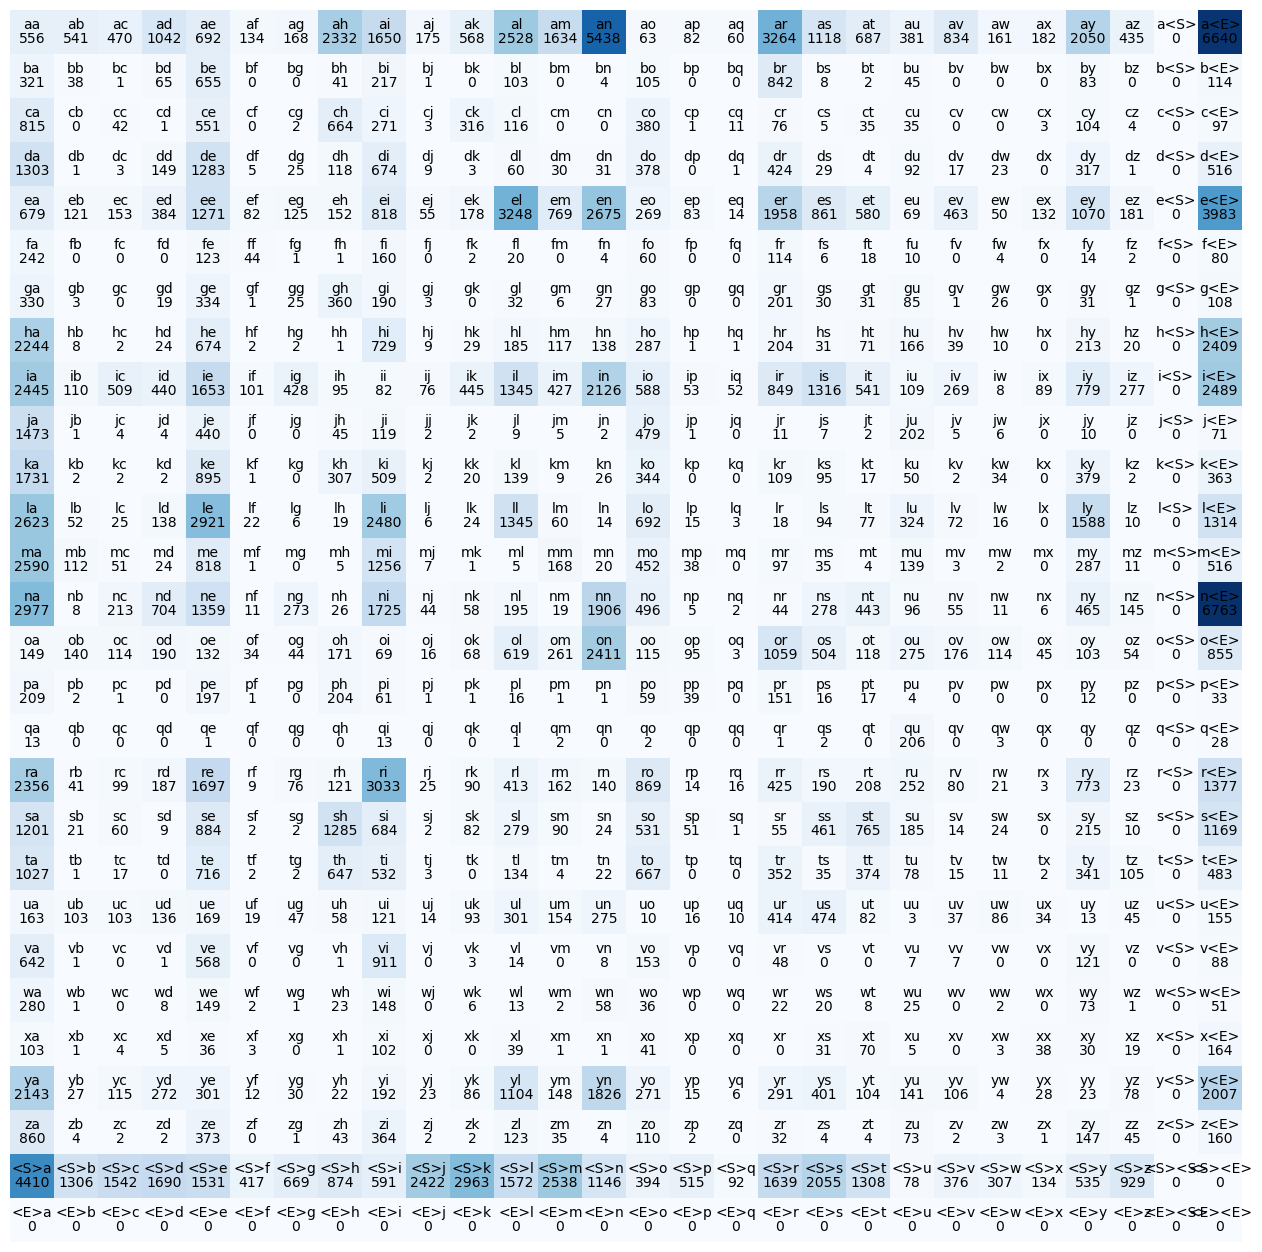

In [8]:
plt.figure(0, (16,16))
plt.imshow(N, cmap='Blues')
plt.axis('off')

for i in range(28):
	for j in range(28):
		bigram = itoc[i]+itoc[j]
		plt.text(j, i, bigram, color='black', va='bottom', ha='center')
		plt.text(j, i, N[i, j].item(), color='black', va='top', ha='center')

With this encoding, we can see that we get a whole row of 0s as no character follows \<E> and a whole column of 0s as no character comes before \<S>. So, even though this may be the conventional form to encode character level models, we can change it by using a single special character in this case to represent the start and end of the string. We will be using '.'

In [9]:
# Get all characters in dataset
chars = sorted(list(set(''.join(words))))

# Convert list of characters to index mapping
ctoi = {c: i+1 for i, c in enumerate(chars)}
ctoi['.'] = 0

# Create reverse mapping
itoc = {i: c for c, i in ctoi.items()}

In [10]:
# We have 27 characters, so we need a 27x27 array
N = torch.zeros((27,27), dtype=torch.int32)

# Populate entries in N
for word in words:
	chars = ['.']+list(word)+['.']
	for ch1, ch2 in zip(chars, chars[1:]):
		idx1, idx2 = ctoi[ch1], ctoi[ch2]
		N[idx1, idx2] += 1

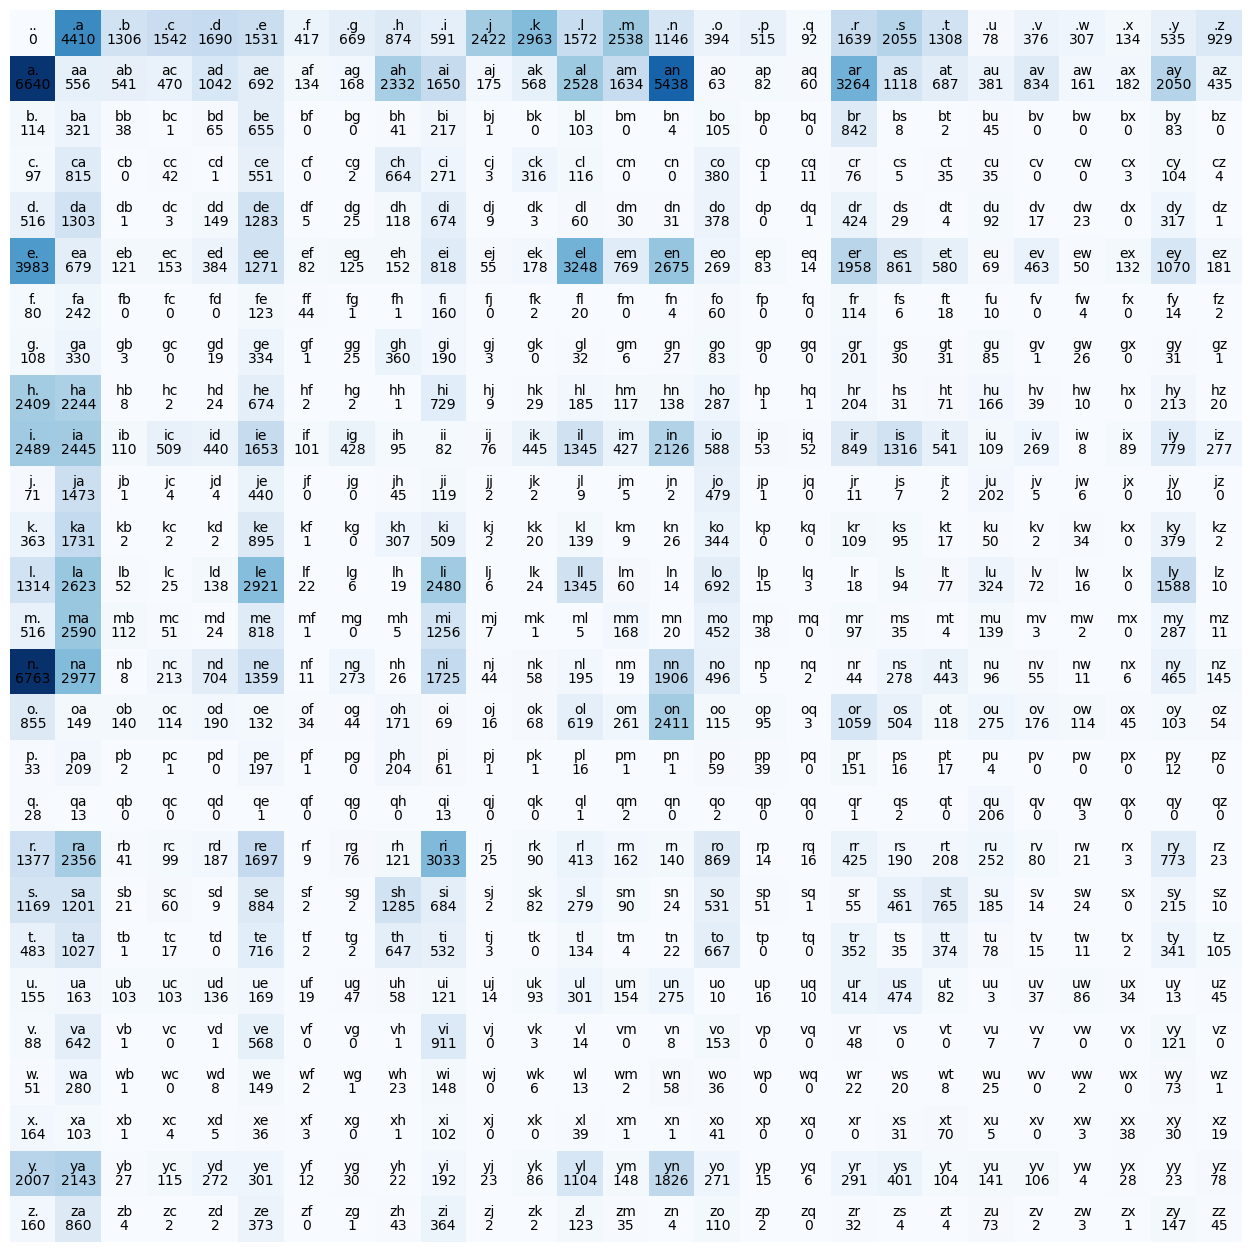

In [11]:
plt.figure(0, (16,16))
plt.imshow(N, cmap='Blues')
plt.axis('off')

for i in range(27):
	for j in range(27):
		bigram = itoc[i]+itoc[j]
		plt.text(j, i, bigram, color='black', va='bottom', ha='center')
		plt.text(j, i, N[i, j].item(), color='black', va='top', ha='center')

Now that we have our counts, we can use it generate a word based on the probability of what the next character will be. We know we always start with a '.' and end similarly. However, we don't want to calculate the probability of the next character from a row in N every time, so instead we can create a separate probability matrix and use that instead.

In [12]:
P = N/N.sum(dim=1, keepdim=True)

In [13]:
newNames = []
numNames = 5
idx = 0
g = torch.Generator().manual_seed(2147483647)

for _ in range(numNames):
	newName = ''
	while True:
		p = P[idx]
		idx = torch.multinomial(p, 1, replacement=True, generator=g).item()
		if idx == 0:
			newNames.append(newName)
			break
		newName += itoc[idx]
	print(newName)

mor
axx
minaymoryles
kondlaisah
anchshizarie


Although we can use this model to generate new names, the names it produces don't look so good. Therefore, we need a quatitative way to judge our model. We can use negative log likelihood as our loss. The likelihood function tells us how likely our model parameters are given our observed training examples on which it is trained. Therefore, it is the joint pmf/pdf of all our training examples given our current model parameters:

$$Likelihood(\theta | X_{1},...,X_{n}) = P(X_{1},...,X_{n} | \theta)$$

In our bigram model, we assume that to predict the current character we only need information of the previous character (except for the special case of starting a word which is always '.'). Therefore, the likelihood function can be broken down to:

$$Likelihood(\theta | X_{1},...,X_{n}) = P(X_{n}| X_{n-1},\theta),...,P(X_{2} | X_{1},\theta)P(X_{1} | '.',\theta)$$

Ideally, we would like to maximize our likelihood function which would in turn mean that we are maximizing the probabilities of seeing our training examples. However, due to the nature of probabilities, the likelihood function would produce very small values. So, instead we can take the log of the likelihood and maximize that as log is a monotonic function and maximizing it means we are maximizing the likelihood function.

$$log likelihood(\theta | X_{1},...,X_{n}) = log(P(X_{n}| X_{n-1},\theta),...,P(X_{2} | X_{1},\theta)P(X_{1} | '.',\theta))$$

$$log likelihood(\theta | X_{1},...,X_{n}) = log(P(X_{n}| X_{n-1},\theta))+...+log(P(X_{2} | X_{1},\theta)) + log(P(X_{1} | '.',\theta))$$

Lastly, because the log of values less than 1 produces negative values, for aesthetic purposes we can take the negative of the log likelihood (ll) to get a positive valued function which we now have to minimize instead of maximizing. The closer the negative log likelihood (nll) is to 0, the better our model.

$$nll = -ll$$

In [14]:
# Calculate the nll for our bigram model
nll = 0.0
n = 0
for word in words:
	chars = ['.']+list(word)+['.']
	for ch1, ch2 in zip(chars, chars[1:]):
		idx1, idx2 = ctoi[ch1], ctoi[ch2]
		p = P[idx1] # probabilities of all characters to follow ch1 (conditioning on ch1)
		nll += -torch.log(p[idx2]) # add the log probability of ch2 to the nll (conditioning on ch1)
		n += 1

# Instead of taking the nll of the whole dataset as a total aggregate, we can average it
# by the number of training examples to get a fairer/smoother representation of the loss and model performance.

print(f'{nll=}')
print(f'Average nll={nll/n}')

nll=tensor(559891.7500)
Average nll=2.454094171524048


We seem to be at a good stage with the modelling of the bigram using frequencies from our training data. However, there is a big issue we have not addressed having introduced the calculation of nll. If we wanted to see how likely a certain name is using our model and nll as the measure, we will run into problems for certain examples.

In [15]:
# Calculate the nll for specific example
nll = 0.0
n = 0
for word in ["suevz"]:
	chars = ['.']+list(word)+['.']
	for ch1, ch2 in zip(chars, chars[1:]):
		idx1, idx2 = ctoi[ch1], ctoi[ch2]
		p = P[idx1] # probabilities of all characters to follow ch1 (conditioning on ch1)
		nll += -torch.log(p[idx2])
		n += 1

print(f'{nll=}')
print(f'Average nll={nll/n}')

nll=tensor(inf)
Average nll=inf


We see from the previous example of trying to calculate the nll of an example such as 'suevz' will give us infinite nll. This is because from our dataset, certain bigrams such as 'vz' have 0 occurrences. This means according to the model it is never likely to happen, and the log of 0 gives us infinity. 

We can fix this issue very easily by introducing smoothing into our model. This is done by introducing some initializing fake count numbers for each bigram. The larger the initializing count we introduce, the more we push our probability distribution for each example towards a uniform distribution as the fake count will dominate the actual count if $$ fakeCount >> actualCount $$.

Therefore, we will only introduce an initial count of 1 into our frequency based bigram model.

In [16]:
N_smooth = N + 1
P_smooth = N_smooth.float()/N_smooth.sum(1, keepdim=True)

In [17]:
# Now calculating the nll for the same example - seuvz
# Calculate the nll for specific example
nll = 0.0
n = 0
for word in ["suevz"]:
	chars = ['.']+list(word)+['.']
	for ch1, ch2 in zip(chars, chars[1:]):
		idx1, idx2 = ctoi[ch1], ctoi[ch2]
		p = P_smooth[idx1] # probabilities of all characters to follow ch1 (conditioning on ch1)
		nll += -torch.log(p[idx2])
		n += 1

print(f'{nll=}')
print(f'Average nll={nll/n}')

nll=tensor(23.8092)
Average nll=3.9682083129882812


So we see that we have solved the infinite nll problem, and our model still tells us that the name we were evaluating is quite unlikely based on the training data it has been fed.

At this point we can conclude that the frequency based bigram model while it is simple to construct does not perform that well, and there is a need for improvement. We therefore look to implement the bigram model using the neural network framework.

NEURAL NETWORK

To train our neural network, we need to construct our dataset of training examples and the corresponding labels. In the bigram case we will use the first character as our input to the network and the second character as the target output for the network.

In [18]:
x, y = [], []

# Populate entries in x, y
for word in words:
	chars = ['.']+list(word)+['.']
	for ch1, ch2 in zip(chars, chars[1:]):
		idx1, idx2 = ctoi[ch1], ctoi[ch2]
		x.append(idx1)
		y.append(idx2)

# convert lists to tensors
x = torch.tensor(x)
y = torch.tensor(y)

In [19]:
# instead of feeding in indices, we will feed in a one-hot encoded vector of each character
import torch.nn.functional as F
xenc = F.one_hot(x, 27).float()

Now that we have our input data and target labels, we also want the weights for our neurons. We will start with one layer of 27 neurons and no biases and activation function.

In [20]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(size=(27, 27), generator=g, dtype=torch.float32, requires_grad=True)

In [23]:
num_iterations = 1000
lr = 10
reg_strength = 0.01

for iter in range(num_iterations):
	# forward pass
	logits = W[x]
	counts = logits.exp()
	probs = counts/counts.sum(1, keepdim=True)
	loss = -probs[torch.arange(x.nelement()), y].log().mean() + reg_strength*(W.data**2).mean()

	# backward pass
	W.grad = None
	loss.backward()

	# update params
	W.data += -lr * W.grad

loss

tensor(2.4834, grad_fn=<AddBackward0>)

In the above loop, the matrix multiplication of xenc and W gives us a matrix which we can think of as the log-counts of the bigrams. NOTE that xenc is a collection of one-hot vectors, and its multiplication with W, essentially picks out the column in W corresponding to the index of the 1 in the one-hot vector (similar to how we index into N based on the current character). Exponentiating this matrix, we get the counts matrix which resembles the matrix N from above, from which we similarly extract probabilities.

Having extracted probabilities, we can calculate the loss - negative log likelihood (plus another term). The loss calculation is similar to the one above, just in a more vectorized form. The second term in the loss acts as the smoothing we added to the matrix N above. By introducing this term, we are forcing the weights of the neurons to be closer to 0 because larger weights would increase the loss. If the weights are 0, then the counts matrix is all 0s and therefore the probabilities are all uniform, which is what would happen if we smoothed N too much as well. Therefore, we want the presence of the second term, but we don't want it to dominate. We can control how much it affects the loss value by scaling it, using the $reg\_strength$ parameter.

Having calculated the loss, we then initiate the backward pass by first setting the grad of W to 0, which can be done efficiently in PyTorch by setting it to None. We can then call backward on loss, propagating the gradients to all weights.

Lastly, we update the weights in the negative direction of the gradients using our learning rate as our step size.

Having trained the model for a few iterations, we can in a similar manner to our previous model use it to predict some names as shown below.

In [24]:
nnNames = []
idx = 0
g = torch.Generator().manual_seed(2147483647)
nnC = W.exp()
nnP = nnC/nnC.sum(1, keepdim=True)

for _ in range(numNames):
	newName = ''
	while True:
		idx = torch.multinomial(nnP[idx], num_samples=1, replacement=True, generator=g).item()
		if idx == 0:
			newNames.append(newName)
			break
		newName += itoc[idx]
	print(newName)

mor
axwaninaymoryles
kondlaisah
anchshizarie
odaren
